# 2023-02-07 • AdEx Nto1

(Based on `2023-01-19__[input]`, which is a distillation of `2022-10-24 • N-to-1 with lognormal inputs`).

In [2]:
cd("/root/phd/pkg/SpikeWorks")
run(`git switch metdeklak`);

Your branch is up to date with 'origin/metdeklak'.


Already on 'metdeklak'


## Imports

In [3]:
#

In [4]:
@showtime using Revise

using Revise: 0.599281 seconds (603.53 k allocations: 36.640 MiB, 3.70% gc time, 1.04% compilation time)


In [5]:
@showtime using MyToolbox
@showtime using SpikeWorks
@showtime using Sciplotlib
@showtime using VoltoMapSim

using MyToolbox: 1.574102 seconds (1.63 M allocations: 104.069 MiB, 2.92% gc time, 0.22% compilation time)
using SpikeWorks: 0.875073 seconds (1.28 M allocations: 78.734 MiB, 5.64% gc time)
using Sciplotlib: 9.385032 seconds (7.10 M allocations: 455.172 MiB, 2.42% gc time, 1.97% compilation time: 100% of which was recompilation)
using VoltoMapSim: 4.136105 seconds (4.98 M allocations: 328.876 MiB, 4.23% gc time)


## AdEx equations & params

This is a distillation of previous notebook.

We base ourselves on

Richard Naud, Nicolas Marcille, Claudia Clopath, and Wulfram Gerstner,\
‘Firing patterns in the adaptive exponential integrate-and-fire model’,\
Biol Cybern, Nov. 2008, https://doi.org/10.1007/s00422-008-0264-7

..and their cortical RS (regular spiking) neuron in table 1.


### Param value comparison, for cortical RS neuron
(Table repeted from prev notebook)

| Naud 2008 AdEx | Val       | Val         | Izh / report  | What
|---------------:|:----------|:------------|:--------------|:----
| $C$            | 104 pF    | 100  pF     | $C$           |
| $C/g_L$        | 24 ms     | ?           | ?             | Time constant of voltage
|                |           | 0.14  ms·mV | $C/k$         | ?
| -------------- | --------- | ------------| --------------|
| $g_L$          | 4.3 nS    | 14  nS      | $k(v_t-v_r)$  | Slope of V̇(V) at rest
| $E_L$          | -65 mV    | -60  mV     | $v_r$         | Rest (stable fixed point)
| $V_T$          | -52 mV    | -50  mV     | $(v_t+v_r)/2$ | Minimum of V̇(V)
|                | -49.6 mV  | -40  mV     | $v_t$         | Threshold (unstable fixed point)
|                | 82 nS     | 14  nS      | $k(v_t-v_r)$  | Slope of V̇(V) at threshold
| $Δ_T$          | 0.8 mV    |             |               |
| -------------- | --------- | ------------| --------------|
| $a$            | -0.8 nS   | -2  nS      | $b$           | Sensitivity of adapt. current
| $τ_w$          | 88 ms     | 33 ms       | $a^{-1}$      | Time ct of adapt. current
| $b$            | 65 pA     | 100  pA     | $d$           | Adapt. current bump after spike
| $V_r$          | -53 mV    | -50  mV     | $c$           | Reset voltage after spike


### Start of code

In [6]:
@typed begin
    # AdEx LIF neuron params (cortical RS)
    C  = 104  * pF
    gₗ = 4.3  * nS
    Eₗ = -65  * mV
    Vₜ = -52  * mV
    Δₜ = 0.8  * mV 
    Vₛ =   0  * mV
    Vᵣ = -53  * mV
    a  = 0.8  * nS
    b  =  65  * pA
    τw =  88  * ms 
    # Conductance-based synapses
    Eₑ =   0 * mV
    Eᵢ = -80 * mV
    τ  =   7 * ms
end;

### Simulated variables and their initial values

In [7]:
x₀ = (
    # AdEx variables
    v   = Vᵣ,      # Membrane potential
    w   = 0 * pA,  # Adaptation current
    # Synaptic conductances g
    gₑ  = 0 * nS,  # = Sum over all exc. synapses
    gᵢ  = 0 * nS,  # = Sum over all inh. synapses
);

$$
\begin{align}
C \frac{dV}{dt}      &= -g_L (V - E_L) + g_L \Delta_T \exp \left( \frac{V - V_T}{\Delta_T} \right) + I - w\\
\tau_w \frac{dw}{dt} &= a (V - E_L) - w
\end{align}
$$

if $V > 0$ mV, then

$$
\begin{align}
V &→ V_r\\
w &→ w + b
\end{align}
$$

### Differential equations:
calculate time derivatives of simulated vars  
(and store them "in-place", in `Dₜ`).

In [8]:
function f!(Dₜ, vars)
    v, w, gₑ, gᵢ = vars

    # Conductance-based synaptic current
    Iₛ = gₑ*(v-Eₑ) + gᵢ*(v-Eᵢ)

    # AdEx 2D system
    Dₜ.v = (-gₗ*(v-Eₗ) + gₗ*Δₜ*exp((v-Vₜ)/Δₜ) - Iₛ - w) / C
    Dₜ.w = (a*(v-Eₗ) - w) / τw

    # Synaptic conductance decay
    Dₜ.gₑ = -gₑ / τ
    Dₜ.gᵢ = -gᵢ / τ
end;

We correct the sign of `Iₛ`.\
From prev nb:
> Positive charges flowing **out** of membrane: Iₘₑₘ pos.\
> Positive charges flowing from electrode **into** cell: Iₑₓₜ pos.

`v` is usually < `Eₑ`,\
so `(v-Eₑ)` will be negative.\
But it should be positive, if we want to have `+ Iₛ` in our `Dₜ.v` equation.

Eh no, I'll keep as is.\
Consistency with Iₘₑₘ (but against convention, yes).

### Spike discontinuity

In [9]:
has_spiked(vars) = (vars.v > Vₛ)

function on_self_spike!(vars)
    vars.v = Vᵣ
    vars.w += b
end;

### Conductance-based AdEx neuron

In [10]:
coba_adex_neuron = NeuronModel(x₀, f!; has_spiked, on_self_spike!);

---


The rest (i.e. the Nto1 part, with E:I) is same

### More parameters, and input spikers

In [11]:
using SpikeWorks.Units
using SpikeWorks: LogNormal

In [12]:
@typed begin
    Δt = 0.1ms
    sim_duration = 10minutes
end

600

Firing rates λ for the Poisson inputs

In [13]:
fr_distr = LogNormal(median = 4Hz, g = 2)

Distributions.LogNormal{Float64}(μ=1.39, σ=0.693)

In [14]:
@enum NeuronType exc inh

In [15]:
input(;
    N = 100,
    EIratio = 4//1,
    scaling = N,
) = begin
    firing_rates = rand(fr_distr, N)
    input_IDs = 1:N
    inputs = [
        Nto1Input(ID, poisson_SpikeTrain(λ, sim_duration))
        for (ID, λ) in zip(input_IDs, firing_rates)
    ]
    # Nₑ, Nᵢ = groupsizes(EIMix(N, EIratio))
    EImix = EIMix(N, EIratio)
    Nₑ = EImix.Nₑ
    Nᵢ = EImix.Nᵢ
    neuron_type(ID) = (ID ≤ Nₑ) ? exc : inh
    Δgₑ = 60nS / scaling
    Δgᵢ = 60nS / scaling * EIratio
    on_spike_arrival!(vars, spike) =
        if neuron_type(source(spike)) == exc
            vars.gₑ += Δgₑ
        else
            vars.gᵢ += Δgᵢ
        end
    return (;
        firing_rates,
        inputs,
        on_spike_arrival!,
        Nₑ,
    )
end;

In [16]:
using SpikeWorks: Simulation, step!, run!, unpack, newsim,
                  get_new_spikes!, next_spike, index_of_next

In [17]:
new(; kw...) = begin
    ip = input(; kw...)
    s = newsim(coba_adex_neuron, ip.inputs, ip.on_spike_arrival!, Δt)
    (sim=s, input=ip)
end;

## Multi sim

(These Ns are same as in e.g. https://tfiers.github.io/phd/nb/2022-10-11__Nto1_output_rate__Edit_of_2022-05-02.html)

In [18]:
using SpikeWorks: spikerate

In [19]:
sim_duration/minutes

10

In [20]:
using Printf
print_Δt(t0) = @printf("%.2G seconds\n", time()-t0)
macro timeh(ex) :( t0=time(); $(esc(ex)); print_Δt(t0) ) end;

In [21]:
Ns_and_scalings = [
    (5,    2.4),   # => N_inh = 1
    (20,   1.3),
        # orig: 21.
        # But: "pₑ = 0.8 does not divide N = 21 into integer parts"
        # So voila
    (100,  0.8),
    (400,  0.6),
    (1600, 0.5),
    (6500, 0.5),
];
Ns = first.(Ns_and_scalings);

In [22]:
nbname = "2023-02-07__AdEx_Nto1"
cachekey(N) = "$(nbname)__N=$(N)__T=$(sim_duration)";
cachekey(Ns[end])

"2023-02-07__AdEx_Nto1__N=6500__T=600"

In [23]:
function runsim(N, scaling)
    println()
    (sim, inp) = new(; N, scaling)
    @show N
    @timeh run!(sim)
    @show spikerate(sim)
    return (; sim, input=inp)
end 

simruns = []
for (N, f) in Ns_and_scalings
    scaling = f*N
    simrun = cached(runsim, (N, scaling), key=cachekey(N))
    push!(simruns, simrun)
end

Loading cached output from `/root/.phdcache/runsim/2023-02-07__AdEx_Nto1__N=5__T=600.jld2` … done (5.4 s)
Loading cached output from `/root/.phdcache/runsim/2023-02-07__AdEx_Nto1__N=20__T=600.jld2` … done (0.1 s)
Loading cached output from `/root/.phdcache/runsim/2023-02-07__AdEx_Nto1__N=100__T=600.jld2` … done (0.1 s)
Loading cached output from `/root/.phdcache/runsim/2023-02-07__AdEx_Nto1__N=400__T=600.jld2` … done (0.1 s)
Loading cached output from `/root/.phdcache/runsim/2023-02-07__AdEx_Nto1__N=1600__T=600.jld2` … done (0.3 s)
Loading cached output from `/root/.phdcache/runsim/2023-02-07__AdEx_Nto1__N=6500__T=600.jld2` … done (0.8 s)


In [24]:
sims = first.(simruns)
inps = last.(simruns);

In [25]:
Base.summarysize(simruns[6]) / GB

0.523

### Disentangle

In [26]:
spiketimes(input::Nto1Input) = input.train.spiketimes;

In [27]:
vrec(s::Simulation{<:Nto1System}) = s.rec.v;

---

/ end same

### Plot

Let's see what this AdEx guy looks like.

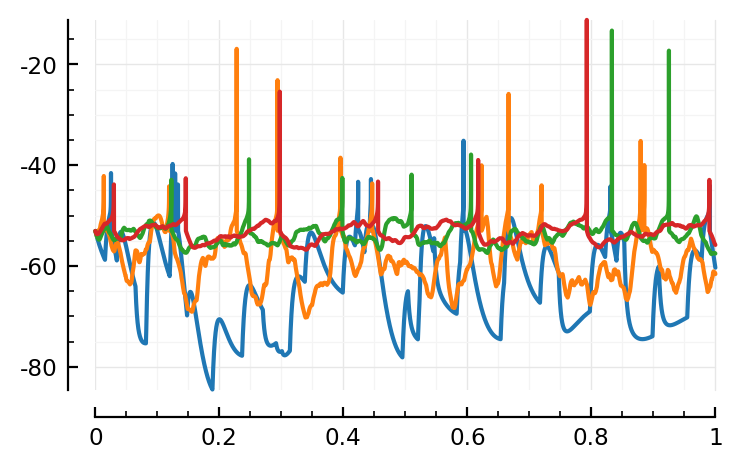

In [28]:
plot1(i) = begin
    s = sims[i]
    Nt = s.stepcounter.N
    t = linspace(0, sim_duration, Nt)
    plotsig(t, vrec(s) / mV; tlim=[0, 1seconds])
end
plot1(1)
plot1(3)
plot1(5)
plot1(6);

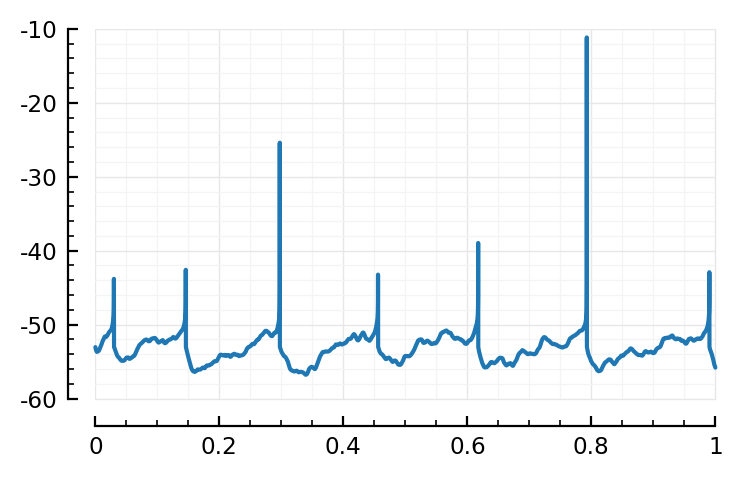

In [29]:
plot1(6);

Now to recreate the plot of https://tfiers.github.io/phd/nb/2022-10-24__Nto1_with_fixed_lognormal_inputs.html#plot

We'll add fake spikes up to our previous' spike cutoff.

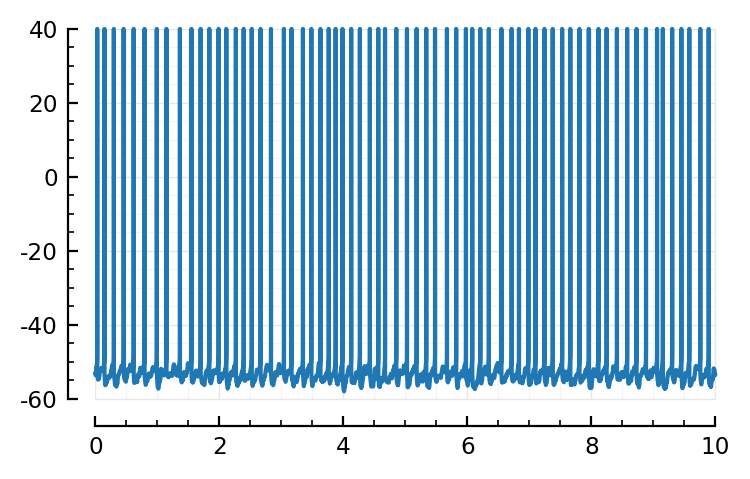

In [30]:
i = 6
s = sims[i]
v = copy(s.rec.v);
v[to_timesteps.(s.rec.spiketimes, Δt)] .= 40mV
Nt = s.stepcounter.N
t = linspace(0, sim_duration, Nt)
plotsig(t, v / mV; tlim=[0, 10seconds]);

## Conntest pooled windows - linear regress 10 ms

In [31]:
i = 6
N = Ns[i]

6500

In [32]:
inp = inps[i];

In [33]:
Nₑ = inp.Nₑ

5200

In [46]:
include("/root/phd/nb/2023-02-07__[input-linefit-wins].jl");

In [47]:
wins = windows(6, 1);
X, y = build_Xy(wins);

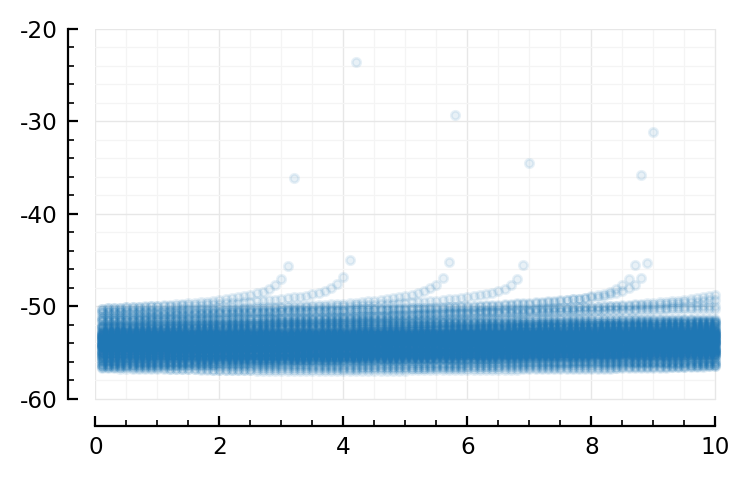

In [48]:
ts = @view X[:,2]
sel = 1:10000

Sciplotlib.plot(ts[sel]*Δt/ms, y[sel]/mV, ".", alpha=0.1);

So we still see our ramp-ups; but much less so.\
(compare, https://tfiers.github.io/phd/nb/2023-01-19__Fit-a-line.html#plot-some-windows)

Now the zoom-in

In [49]:
Ny = length(y)

280500

(only 0.3M datapoints here; but in the other nb we used our highest-firing).

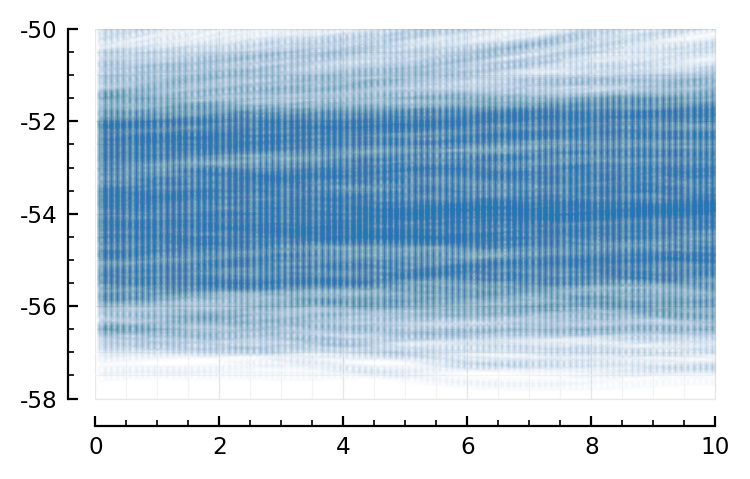

In [50]:
sel = 1:100_000
Sciplotlib.plot(
    ts[sel]*Δt/ms,
    y[sel]/mV,
    ".";
    alpha = 0.01,
    ylim = [-58, -50],  # mV
    clip_on = true,
);

In [51]:
inh_neurons = Nₑ+1:N;

In [52]:
spiketimes(i::Int) = spiketimes(inp.inputs[i]);

In [53]:
shuffle_sources = sample(1:N, 100, replace=true)

real_spiketrains = spiketimes.(1:N);
unconnected_trains = shuffle_ISIs.(spiketimes.(shuffle_sources));

In [54]:
all_spiketrains = [real_spiketrains; unconnected_trains];

In [55]:
using Base.Threads: @threads

In [56]:
Nrows = length(all_spiketrains)

6600

(Below calc takes 3'25 on laptop, 7 threads)

In [58]:
makerows() = begin
    rows = Vector(undef, Nrows)
    p = Progress(Nrows)
    @threads for r in 1:Nrows
        rows[r] = makerow(r)
        next!(p)
    end
    return rows
end;

rows = cached(makerows, (), key=cachekey(N));

Loading cached output from `/root/.phdcache/makerows/2023-02-07__AdEx_Nto1__N=6500__T=600.jld2` … done (0.1 s)


In [61]:
df = DataFrame(rows)
disp(df, 5)  # (huh, disp no work no more here)

Row,conntype,slope,pval,predtype
,Symbol,Float64,Float64,Symbol
1,exc,-0.28,0.813,unconn
2,exc,0.828,0.584,unconn
3,exc,3.78,1.44E-05,exc
4,exc,5.42,0.00335,unconn
5,exc,1.85,0.0458,unconn
6,exc,4.7,9.53E-05,exc
7,exc,-1.3,0.26,unconn
8,exc,8.08,0.000785,exc
9,exc,1.65,0.00208,unconn


In [62]:
perftable(df)

Tested connections: 6600,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,86,3712,730,,2%
Predicted type,exc,11,1326,10,,98%
└,inh,3,161,561,,77%
,,,,,,
Sensitivity,,86%,26%,43%,,


At this arbitrary ‘α’ = 0.001:
- FPR: 14%
- TPRₑ: 26%
- TPRᵢ: 43%

Comparing with the results with the Izh neuron:\
(https://tfiers.github.io/phd/nb/2023-01-19__Fit-a-line.html#proper-eval)\
- FPR: 34%
- TPRₑ: 24%
- TPRᵢ: 37%

So, that seems like a def increase :)

### Now with lower FPR / lower α

In [141]:
Nrows = length(all_spiketrains)
# Nrows = 20

6600

In [142]:
α=0.0001;
rows2 = Vector(undef, Nrows)
p = Progress(Nrows)
@threads for r in 1:Nrows
    rows2[r] = makerow(r; α)
    next!(p)
end;
df2 = DataFrame(rows2)
perftable(df2)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:54Progress:  73%|█████████████████████████████▊           |  ETA: 0:01:21


Tested connections: 6600,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,84,4143,857,,2%
Predicted type,exc,3,965,2,,99%
└,inh,13,91,442,,81%
,,,,,,
Sensitivity,,84%,19%,34%,,


(FPR 16%)

### Even lowerr

It's dumb to recalculate; we have the p-values.

(Plus, there's some memory thing it seems: process dies halfway here).

In [85]:
update_predtype(row::DataFrameRow; α) = begin
    if row.pval < α
        predtype = (row.slope > 0 ? :exc : :inh)
    else
        predtype = :unconn
    end
    row.predtype = predtype
end;

df3 = deepcopy(df)
foreach(row -> update_predtype(row, α = 0.0000008), eachrow(df3))
perftable(df3)

Tested connections: 6600,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,95,4666,1019,,2%
Predicted type,exc,5,501,1,,99%
└,inh,0,32,281,,90%
,,,,,,
Sensitivity,,95%,10%,22%,,


:D

## Conntest STA

In [27]:
winsize = 1000

calcSTA(sim, spiketimes) =
    calc_STA(vrec(sim), spiketimes, sim.Δt, winsize);

In [28]:
# @code_warntype calc_STA(vrec(s), st1, s.Δt, winsize)
# all good

### Cache STA calc

In [29]:
using Base.Threads: @threads

In [30]:
function calc_STA_and_shufs(spiketimes, sim)
    realSTA = calcSTA(sim, spiketimes)
    shufs = [
        calcSTA(sim, shuffle_ISIs(spiketimes))
        for _ in 1:100
    ]
    (; realSTA, shufs)
end

"calc_all_STAs_and_shufs"
function calc_all_STAz(inputs, sim)
    f(input) = calc_STA_and_shufs(spiketimes(input), sim)
    N = length(inputs)
    res = Vector(undef, N)
    p = Progress(N)
    # @threads for i in 1:N
    for i in 1:N
        res[i] = f(inputs[i])
        next!(p)
    end
    res
end
calc_all_STAz(simrun) = calc_all_STAz(unpakk(simrun)...);
unpakk(simrun) = (; simrun.input.inputs, simrun.sim);

# out = calc_all_STAz(simruns[1])
# print(Base.summary(out))

In [ ]:
calc_all_cached(i) = cached(calc_all_STAz, [simruns[i]], key=cachekey(Ns[i]))

out = []
for i in eachindex(simruns)
    push!(out, calc_all_cached(i))
end;

Loading cached output from `/root/.phdcache/calc_all_STAz/2023-02-07__AdEx_Nto1__N=5__T=600.jld2` … done (0.3 s)
Loading cached output from `/root/.phdcache/calc_all_STAz/2023-02-07__AdEx_Nto1__N=20__T=600.jld2` … done
Loading cached output from `/root/.phdcache/calc_all_STAz/2023-02-07__AdEx_Nto1__N=100__T=600.jld2` … done (0.2 s)
Loading cached output from `/root/.phdcache/calc_all_STAz/2023-02-07__AdEx_Nto1__N=400__T=600.jld2` … done (1.0 s)
Loading cached output from `/root/.phdcache/calc_all_STAz/2023-02-07__AdEx_Nto1__N=1600__T=600.jld2` … done (4.8 s)
Progress:  55%|██████████████████████▍                  |  ETA: 0:15:39

In [31]:
conntype_vec(i) = begin
    sim, inp = simruns[i]
    Nₑ = inp.Nₑ
    N = Ns[i]
    conntype = Vector{Symbol}(undef, N);
    conntype[1:Nₑ]     .= :exc
    conntype[Nₑ+1:end] .= :inh
    conntype
end;

In [32]:
conntestresults(i, teststat = ptp_test; α = 0.05) = begin
    
    f((sta, shufs)) = test_conn(teststat, sta, shufs; α)
    res = @showprogress map(f, out[i])
    df = DataFrame(res)
    df[!, :conntype] = conntype_vec(i)
    df
end;

# conntestresults(1)

In [33]:
using Sciplotlib: plot

In [34]:
spikerate_(spiketimes) = length(spiketimes) / sim_duration;

In [34]:
spikerate_(inp::Nto1Input) = spikerate_(spiketimes(inp));

In [35]:
firing_rates(i) = spikerate_.(spiketimes.(inps[i].inputs));